# 3D-BPP

## Pre-requisites

In [2]:
import sys

sys.path.append("src/")

In [3]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

import config, dataset, main, utils, bins

In [4]:
%matplotlib notebook
%reload_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [5]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

C:\Users\gbencheikh\AppData\Local\Temp\ipykernel_30768\3634308497.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [6]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,284,226,119,25,7637896
1,299,207,137,90,8479341
2,534,372,229,41,45490392
3,295,134,232,31,9170960
4,266,186,178,54,8806728


<IPython.core.display.Javascript object>

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.0000e+00,
        0.0000e+00, 9.0000e+00, 2.0000e+01, 1.6000e+01, 2.8000e+01,
        5.9000e+01, 3.3000e+01, 5.6000e+01, 7.8000e+01, 1.2100e+02,
        1.5300e+02, 1.7800e+02, 2.6000e+02, 3.5000e+02, 4.0700e+02,
        5.5000e+02, 7.1600e+02, 8.8700e+02, 1.1060e+03, 1.3300e+03,
        1.6280e+03, 2.0910e+03, 2.4920e+03, 2.9780e+03, 3.5390e+03,
        4.4800e+03, 5.2350e+03, 5.8350e+03, 7.1990e+03, 7.3420e+03,
        9.9740e+03, 1.0665e+04, 1.2038e+04, 1.3355e+04, 1.5169e+04,
        1.7033e+04, 1.8427e+04, 2.0262e+04, 2.1979e+04, 2.2607e+04,
        2.6150e+04, 2.7031e+04, 2.8449e+04, 2.9547e+04, 3.0813e+04,
        3.1271e+04, 3.2881e+04, 3.3104e+04, 3.4202e+04, 3.4606e+04,
        3.3121e+04, 3.3439e+04, 3.2588e+04, 3.18

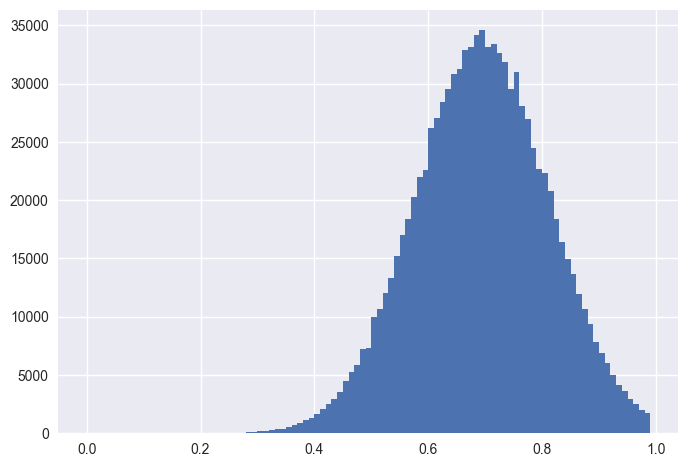

<IPython.core.display.Javascript object>

In [7]:
%matplotlib inline
plt.figure()
plt.hist(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 1, 0.01),
)

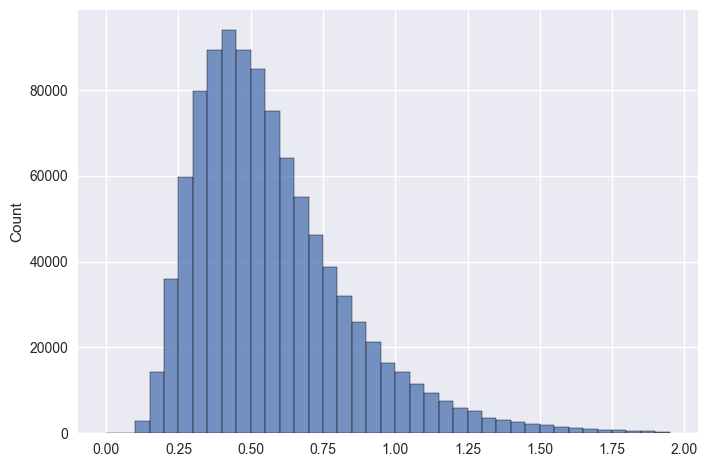

<IPython.core.display.Javascript object>

In [8]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 2, 0.05),
)
plt.show()

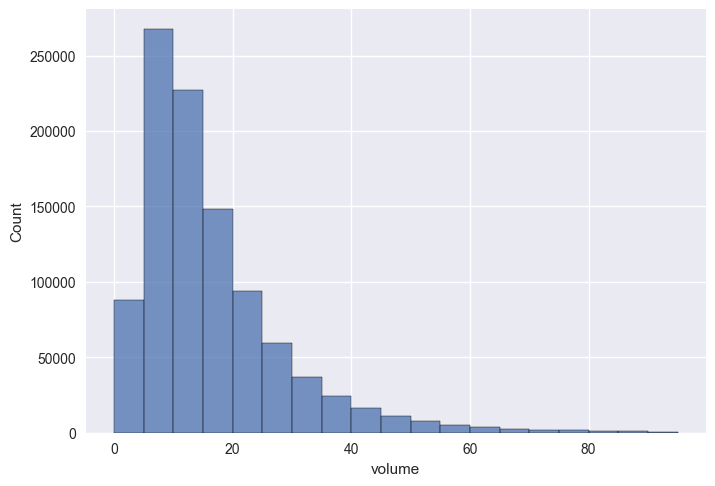

<IPython.core.display.Javascript object>

In [9]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

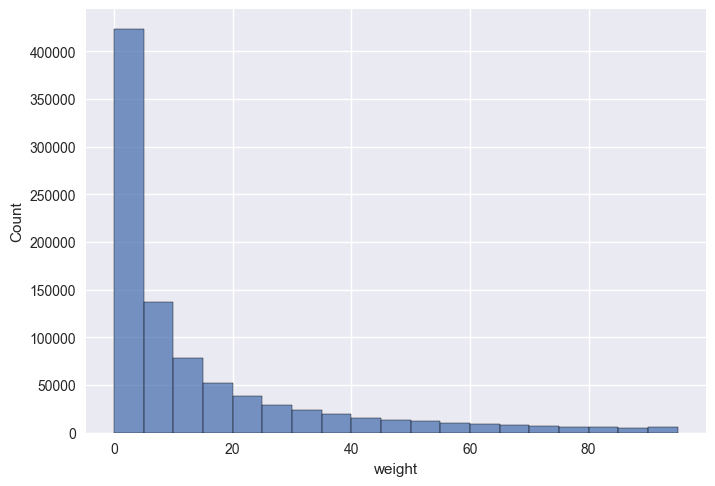

<IPython.core.display.Javascript object>

In [10]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

### Order

In [11]:
ordered_products = 100
order = product_dataset.get_order(ordered_products)
# order = pd.read_csv("data/test_order.csv")
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,367,270,186,3,18430740
1,671155,343,203,194,4,13508026
2,131932,242,157,92,97,3495448
3,365838,503,351,146,2,25776738
4,259178,359,200,183,6,13139400


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [12]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [13]:
utils.get_l1_lb(order, config.PALLET_DIMS)

100%|██████████| 100/100 [00:00<00:00, 1578.34it/s]


(1.0, 0.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

In [14]:
utils.get_l2_lb(order, config.PALLET_DIMS)

100%|██████████| 100/100 [00:00<00:00, 1442.57it/s]
9900it [00:28, 341.55it/s]
9702it [00:47, 202.96it/s]
9800it [00:40, 240.69it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [15]:
bl_order = product_dataset.get_order(20)

<IPython.core.display.Javascript object>

In [16]:
dimensions = utils.Dimension(50, 50, 50, 50)

<IPython.core.display.Javascript object>

In [20]:
bl_bin_pool = main.main(bl_order, procedure="bl", tlim=20)
bl_bin_pool.get_original_layer_pool().to_dataframe()

2023-11-24 10:50:41.284 | INFO     | main:main:169 - BL procedure starting
2023-11-24 10:50:41.285 | INFO     | main:main:179 - BL iteration 1/1
2023-11-24 10:50:41.288 | DEBUG    | utils:_gen_single_items_superitems:1082 - Generated 20 superitems with a single item
2023-11-24 10:50:41.290 | INFO     | utils:gen_superitems:1066 - Generating horizontal superitems of type 'two-width'
2023-11-24 10:50:41.290 | DEBUG    | utils:_gen_superitems_horizontal:1128 - Generated 0 horizontal superitems with 2 items
2023-11-24 10:50:41.291 | DEBUG    | utils:_gen_superitems_horizontal:1135 - Generated 0 horizontal superitems with 4 items
2023-11-24 10:50:41.291 | INFO     | utils:gen_superitems:1069 - Generating vertical superitems with maximum stacking of 4
2023-11-24 10:50:41.292 | DEBUG    | utils:_gen_superitems_vertical:1213 - Generated 20 wide vertical superitems
2023-11-24 10:50:41.292 | DEBUG    | utils:_gen_superitems_vertical:1215 - Generated 0 deep vertical superitems
2023-11-24 10:50:41

,item,x,y,z,width,depth,height,layer
0,16,0,0,0,498,356,280,0
1,11,0,356,0,476,361,198,0
2,13,476,356,0,500,308,142,0
3,15,498,0,0,482,309,272,0
4,4,976,309,0,224,197,153,0
5,7,976,506,0,189,158,87,0
6,5,980,0,0,208,138,127,0
7,14,0,0,0,333,285,106,1
8,3,0,285,0,349,268,277,1
9,8,333,0,0,338,271,189,1


<IPython.core.display.Javascript object>

In [21]:
bl_bin_pool.get_original_layer_pool().describe()

,layer,height,area,volume,2d_density,3d_density
0,0,280.0,754756.0,159038290.0,0.786204,0.591660
1,1,431.0,763709.0,148397810.0,0.795530,0.358657
2,2,525.0,104610.0,37363824.0,0.108969,0.074135
3,Total,1236.0,1623075.0,344799924.0,0.563568,0.341484


<IPython.core.display.Javascript object>

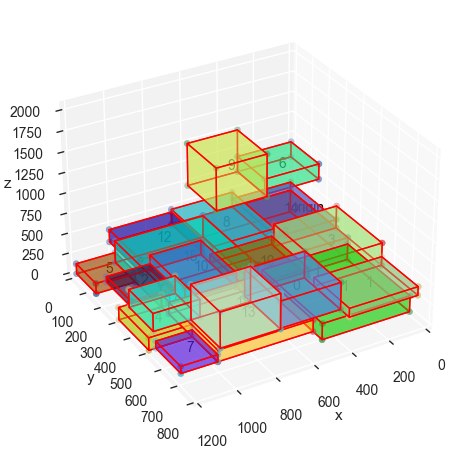

<IPython.core.display.Javascript object>

In [22]:
bl_bin_pool.get_original_bin_pool().plot();

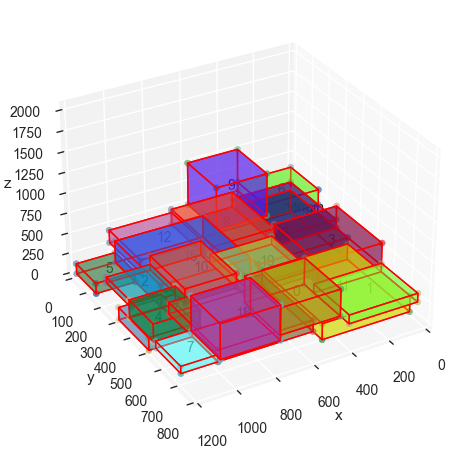

<IPython.core.display.Javascript object>

In [23]:
bl_bin_pool.plot();

## Maxrects

In [24]:
mr_bin_pool = main.main(
    order,
    procedure="mr",
    superitems_horizontal=True,
    superitems_horizontal_type="two-width",
)
mr_bin_pool.get_original_layer_pool().to_dataframe()

2023-11-24 10:51:53.613 | INFO     | main:main:169 - MR procedure starting
2023-11-24 10:51:53.616 | INFO     | main:main:179 - MR iteration 1/1
2023-11-24 10:51:53.622 | DEBUG    | utils:_gen_single_items_superitems:1082 - Generated 100 superitems with a single item
2023-11-24 10:51:53.622 | INFO     | utils:gen_superitems:1066 - Generating horizontal superitems of type 'two-width'
2023-11-24 10:51:53.623 | DEBUG    | utils:_gen_superitems_horizontal:1128 - Generated 0 horizontal superitems with 2 items
2023-11-24 10:51:53.624 | DEBUG    | utils:_gen_superitems_horizontal:1135 - Generated 0 horizontal superitems with 4 items
2023-11-24 10:51:53.624 | INFO     | utils:gen_superitems:1069 - Generating vertical superitems with maximum stacking of 4
2023-11-24 10:51:53.626 | DEBUG    | utils:_gen_superitems_vertical:1213 - Generated 105 wide vertical superitems
2023-11-24 10:51:53.626 | DEBUG    | utils:_gen_superitems_vertical:1215 - Generated 0 deep vertical superitems
2023-11-24 10:51:

,item,x,y,z,width,depth,height,layer
0,42,0,0,0,1059,506,243,0
1,18,0,0,0,360,311,101,1
2,96,0,311,0,327,192,98,1
3,54,0,503,0,197,166,95,1
4,38,197,503,0,327,250,93,1
...,...,...,...,...,...,...,...,...
95,21,343,614,0,356,186,273,12
96,77,824,0,0,324,198,267,12
97,6,824,198,0,323,248,298,12
98,85,0,0,0,514,240,280,13


<IPython.core.display.Javascript object>

In [25]:
mr_bin_pool.get_original_layer_pool().describe()

,layer,height,area,volume,2d_density,3d_density
0,0,243.0,535854.0,1.302125e+08,0.558181,0.558181
1,1,101.0,646199.0,5.658190e+07,0.673124,0.583559
2,2,122.0,664567.0,7.447236e+07,0.692257,0.635864
3,3,131.0,728224.0,9.368035e+07,0.758567,0.744914
4,4,143.0,622629.0,8.592633e+07,0.648572,0.625920
5,5,152.0,710123.0,1.022736e+08,0.739711,0.700888
6,6,168.0,757739.0,1.220512e+08,0.789311,0.756766
7,7,186.0,699435.0,1.242738e+08,0.728578,0.695978
8,8,194.0,621406.0,1.168051e+08,0.647298,0.627175
9,9,219.0,703362.0,1.421316e+08,0.732669,0.676045


<IPython.core.display.Javascript object>

[<Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>]

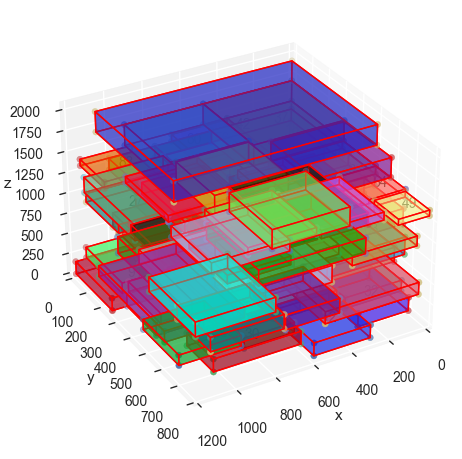

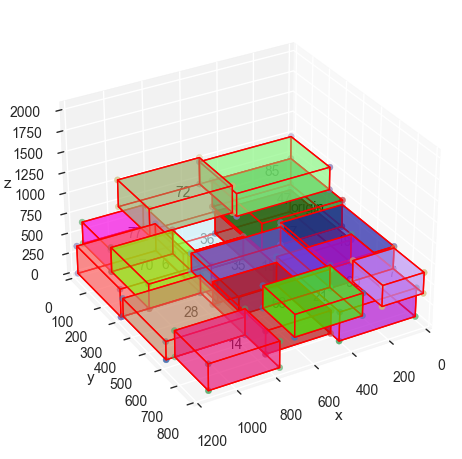

<IPython.core.display.Javascript object>

In [26]:
mr_bin_pool.get_original_bin_pool().plot()

[<Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>]

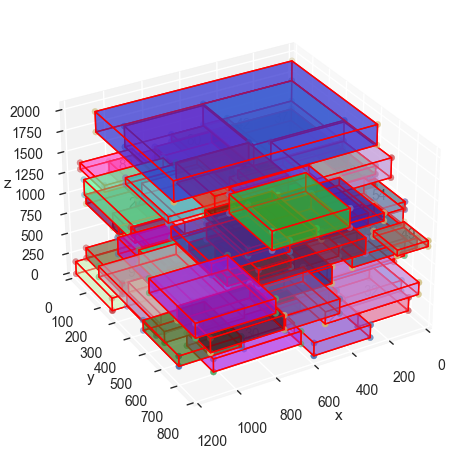

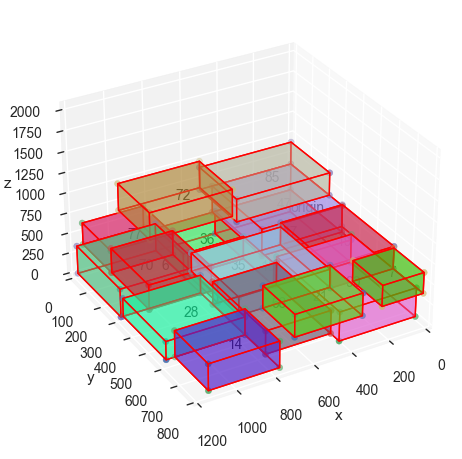

<IPython.core.display.Javascript object>

In [27]:
mr_bin_pool.plot()

## Column generation

In [ ]:
cg_bin_pool = main.main(
    order,
    procedure="cg",
    max_iters=1,
    superitems_horizontal=True,
    superitems_horizontal_type="two-width",
    tlim=10,
    cg_use_height_groups=False,
    cg_mr_warm_start=False,
    cg_max_iters=100,
    cg_max_stag_iters=10,
    cg_sp_mr=True,
    cg_sp_np_type="mip",
    cg_sp_p_type="mr",
    cg_return_only_last=False,
)
cg_bin_pool.get_original_layer_pool().to_dataframe()

2021-09-15 19:34:22.257 | INFO     | main:main:169 - CG procedure starting
2021-09-15 19:34:22.258 | INFO     | main:main:179 - CG iteration 1/1
2021-09-15 19:34:22.269 | DEBUG    | superitems:_gen_single_items_superitems:639 - Generated 100 superitems with a single item
2021-09-15 19:34:22.270 | INFO     | superitems:gen_superitems:623 - Generating horizontal superitems of type 'two-width'
2021-09-15 19:34:22.271 | DEBUG    | superitems:_gen_superitems_horizontal:685 - Generated 0 horizontal superitems with 2 items
2021-09-15 19:34:22.272 | DEBUG    | superitems:_gen_superitems_horizontal:692 - Generated 0 horizontal superitems with 4 items
2021-09-15 19:34:22.272 | INFO     | superitems:gen_superitems:626 - Generating vertical superitems with maximum stacking of 4
2021-09-15 19:34:22.274 | DEBUG    | superitems:_gen_superitems_vertical:770 - Generated 80 wide vertical superitems
2021-09-15 19:34:22.276 | DEBUG    | superitems:_gen_superitems_vertical:772 - Generated 24 deep vertical 

2021-09-15 19:34:23.146 | DEBUG    | column_generation:master_problem:123 - RMP constraints: 100
2021-09-15 19:34:23.148 | DEBUG    | column_generation:master_problem:125 - RMP iterations: 89
2021-09-15 19:34:23.149 | INFO     | column_generation:master_problem:131 - RMP solved
2021-09-15 19:34:23.150 | DEBUG    | column_generation:master_problem:135 - RMP alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

2021-09-15 19:34:23.781 | DEBUG    | column_generation:master_problem:137 - RMP solution not feasible (at least one alpha value is not binary)
2021-09-15 19:34:23.782 | DEBUG    | column_generation:master_problem:141 - RMP objective: 3938.0000000000005
2021-09-15 19:34:23.783 | DEBUG    | column_generation:master_problem:146 - RMP duals: [  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  323.    0.    0.    0.    0.    0.  441.    0.    0.    0.
   0.    0.  349.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  325.  283.5   0.    0.    0.    0.    0.    0.
  13.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.  289.    0.    0.    0.  231.    0.
   0.    0.    0.  313.    0.  387.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.  290.    0.    0.    0.  330.    0.  363.
   0.    0.    0.    0. ]
2021-09-15 19:34:23.784 | DEBUG    | column_generation:mas

2021-09-15 19:34:24.390 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.277
2021-09-15 19:34:24.393 | DEBUG    | column_generation:column_generation:654 - CG stagnation 4/10
2021-09-15 19:34:24.393 | INFO     | column_generation:pricing_problem_maxrects:160 - SP-MR starting computation
2021-09-15 19:34:24.397 | DEBUG    | maxrects:maxrects_single_layer_online:138 - MR-SL-Online starting
2021-09-15 19:34:24.399 | DEBUG    | maxrects:maxrects_single_layer_online:147 - MR-SL-Online 36 non-zero duals to place
2021-09-15 19:34:24.415 | DEBUG    | maxrects:maxrects_single_layer_online:196 - MR-SL-Online generated a new layer with 17 superitems (of which 12 with non-zero dual) and 0.44136730684488834 3D density
2021-09-15 19:34:24.416 | DEBUG    | column_generation:pricing_problem_maxrects:166 - SP-MR solved
2021-09-15 19:34:24.417 | DEBUG    | column_generation:pricing_problem_maxrects:170 - SP-MR time: 0.02260303497314453
2021-09-15 19:34:24.418 | INFO     | column_generatio

2021-09-15 19:34:25.001 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.278
2021-09-15 19:34:25.006 | DEBUG    | column_generation:column_generation:654 - CG stagnation 6/10
2021-09-15 19:34:25.007 | INFO     | column_generation:pricing_problem_maxrects:160 - SP-MR starting computation
2021-09-15 19:34:25.011 | DEBUG    | maxrects:maxrects_single_layer_online:138 - MR-SL-Online starting
2021-09-15 19:34:25.014 | DEBUG    | maxrects:maxrects_single_layer_online:147 - MR-SL-Online 44 non-zero duals to place
2021-09-15 19:34:25.030 | DEBUG    | maxrects:maxrects_single_layer_online:196 - MR-SL-Online generated a new layer with 17 superitems (of which 14 with non-zero dual) and 0.4742106267197327 3D density
2021-09-15 19:34:25.031 | DEBUG    | column_generation:pricing_problem_maxrects:166 - SP-MR solved
2021-09-15 19:34:25.031 | DEBUG    | column_generation:pricing_problem_maxrects:170 - SP-MR time: 0.02365899085998535
2021-09-15 19:34:25.032 | INFO     | column_generation

2021-09-15 19:34:25.631 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.284
2021-09-15 19:34:25.635 | DEBUG    | column_generation:column_generation:654 - CG stagnation 8/10
2021-09-15 19:34:25.635 | INFO     | column_generation:pricing_problem_maxrects:160 - SP-MR starting computation
2021-09-15 19:34:25.639 | DEBUG    | maxrects:maxrects_single_layer_online:138 - MR-SL-Online starting
2021-09-15 19:34:25.642 | DEBUG    | maxrects:maxrects_single_layer_online:147 - MR-SL-Online 53 non-zero duals to place
2021-09-15 19:34:25.657 | DEBUG    | maxrects:maxrects_single_layer_online:196 - MR-SL-Online generated a new layer with 18 superitems (of which 16 with non-zero dual) and 0.36033551800100705 3D density
2021-09-15 19:34:25.658 | DEBUG    | column_generation:pricing_problem_maxrects:166 - SP-MR solved
2021-09-15 19:34:25.658 | DEBUG    | column_generation:pricing_problem_maxrects:170 - SP-MR time: 0.02237391471862793
2021-09-15 19:34:25.659 | INFO     | column_generatio

2021-09-15 19:34:26.274 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.299
2021-09-15 19:34:26.279 | DEBUG    | column_generation:column_generation:654 - CG stagnation 10/10
2021-09-15 19:34:26.279 | ERROR    | column_generation:column_generation:658 - CG exiting for stagnation
2021-09-15 19:34:26.283 | INFO     | layers:filter_layers:483 - Filtering 111 generated layers
2021-09-15 19:34:26.288 | DEBUG    | layers:filter_layers:485 - Remaining 2 layers after discarding by 0.5 density
2021-09-15 19:34:26.290 | DEBUG    | layers:filter_layers:489 - Remaining 2 layers after discarding by coverage (all: 3, single: 3)
2021-09-15 19:34:26.314 | DEBUG    | maxrects:maxrects_single_layer_offline:88 - MR-SL-Offline starting
2021-09-15 19:34:26.315 | DEBUG    | maxrects:maxrects_single_layer_offline:94 - MR-SL-Offline [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]/14 superitems to place
2021-09-15 19:34:26.323 | ERROR    | layers:remove_duplicated_items:459 - After removing duplica

,item,x,y,z,width,depth,height,layer
0,29,0,22,0,286,162,450,0
1,76,5,18,450,275,171,380,0
2,18,29,0,830,228,207,292,0
3,4,16,8,1122,253,191,580,0
4,27,0,246,0,366,256,654,0
...,...,...,...,...,...,...,...,...
95,34,244,0,0,231,176,329,3
96,22,244,176,0,294,136,440,3
97,61,475,0,0,239,159,354,3
98,94,341,312,0,231,128,345,3


<IPython.core.display.Javascript object>

In [ ]:
cg_bin_pool.get_original_layer_pool().describe()

,layer,height,area,volume,2d_density,3d_density
0,0,1702.0,837966.0,9.786522e+08,0.872881,0.598960
1,1,289.0,828939.0,2.121444e+08,0.863478,0.764650
2,2,519.0,860836.0,3.328284e+08,0.896704,0.668008
3,3,440.0,422781.0,1.465704e+08,0.440397,0.346994
4,Total,2950.0,2950522.0,1.670196e+09,0.768365,0.594653


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


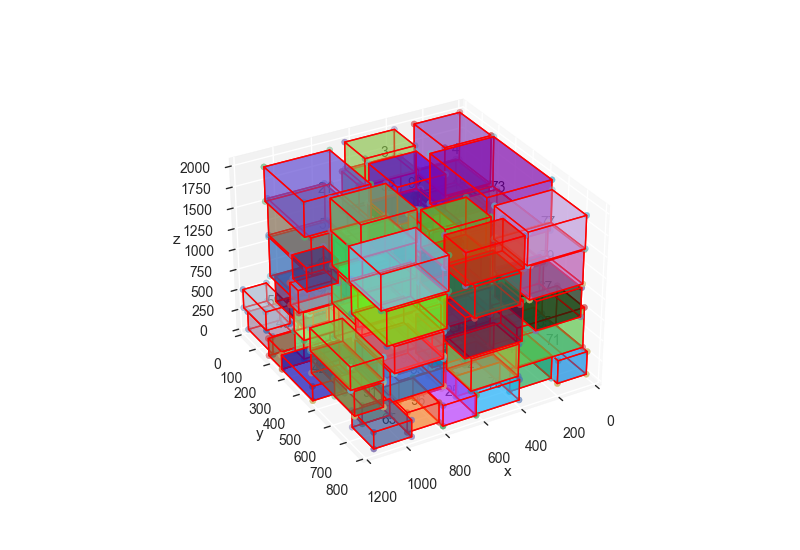

<IPython.core.display.Javascript object>


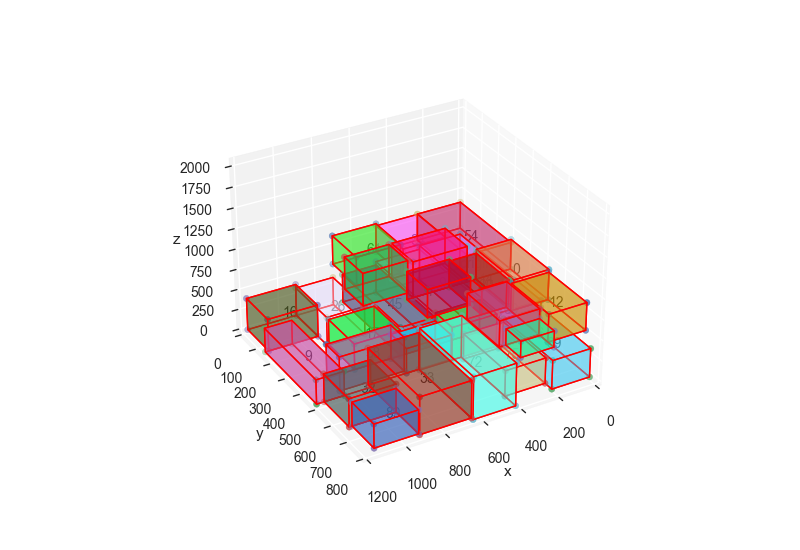

[<Axes3DSubplot:xlabel='x', ylabel='y'>,
 <Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [ ]:
cg_bin_pool.get_original_bin_pool().plot()

<IPython.core.display.Javascript object>


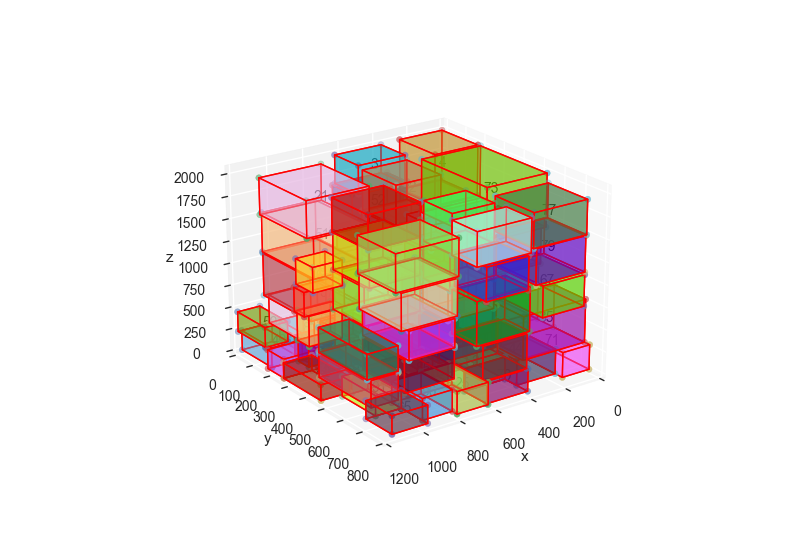

<IPython.core.display.Javascript object>


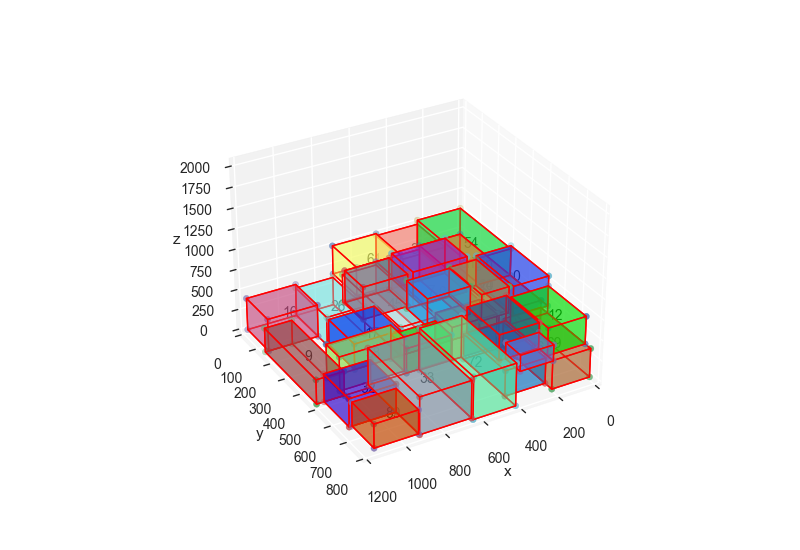

[<Axes3DSubplot:xlabel='x', ylabel='y'>,
 <Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [ ]:
cg_bin_pool.plot()